<a href="https://colab.research.google.com/github/muralikandan/fraud_detection/blob/main/fraud_detection_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_curve, auc, accuracy_score,f1_score,confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import time

In [4]:
# Load the dataset (replace 'auto_loan_data.csv' with your dataset)
loan_df = pd.read_csv('sample_data/financial_loan.csv')

**Understanding the Features**

In [67]:
#Data Exploration
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38576 entries, 0 to 38575
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     38576 non-null  int64  
 1   address_state          38576 non-null  object 
 2   application_type       38576 non-null  object 
 3   emp_length             38576 non-null  object 
 4   emp_title              37138 non-null  object 
 5   grade                  38576 non-null  object 
 6   home_ownership         38576 non-null  object 
 7   issue_date             38576 non-null  object 
 8   last_credit_pull_date  38576 non-null  object 
 9   last_payment_date      38576 non-null  object 
 10  loan_status            38576 non-null  object 
 11  next_payment_date      38576 non-null  object 
 12  member_id              38576 non-null  int64  
 13  purpose                38576 non-null  object 
 14  sub_grade              38576 non-null  object 
 15  te

In [4]:
loan_df.head()

,id,address_state,application_type,emp_length,emp_title,grade,home_ownership,issue_date,last_credit_pull_date,last_payment_date,...,sub_grade,term,verification_status,annual_income,dti,installment,int_rate,loan_amount,total_acc,total_payment
0,1077430,GA,INDIVIDUAL,< 1 year,Ryder,C,RENT,11-02-2021,13-09-2021,13-04-2021,...,C4,60 months,Source Verified,30000.0,0.0100,59.83,0.1527,2500,4,1009
1,1072053,CA,INDIVIDUAL,9 years,MKC Accounting,E,RENT,01-01-2021,14-12-2021,15-01-2021,...,E1,36 months,Source Verified,48000.0,0.0535,109.43,0.1864,3000,4,3939
2,1069243,CA,INDIVIDUAL,4 years,Chemat Technology Inc,C,RENT,05-01-2021,12-12-2021,09-01-2021,...,C5,36 months,Not Verified,50000.0,0.2088,421.65,0.1596,12000,11,3522
3,1041756,TX,INDIVIDUAL,< 1 year,barnes distribution,B,MORTGAGE,25-02-2021,12-12-2021,12-03-2021,...,B2,60 months,Source Verified,42000.0,0.0540,97.06,0.1065,4500,9,4911
4,1068350,IL,INDIVIDUAL,10+ years,J&J Steel Inc,A,MORTGAGE,01-01-2021,14-12-2021,15-01-2021,...,A1,36 months,Verified,83000.0,0.0231,106.53,0.0603,3500,28,3835


In [6]:
# Check for spread of various features
loan_df['emp_length'].value_counts()

emp_length
10+ years    8870
< 1 year     4575
2 years      4382
3 years      4088
4 years      3428
5 years      3273
1 year       3229
6 years      2228
7 years      1772
8 years      1476
9 years      1255
Name: count, dtype: int64

In [7]:
loan_df['home_ownership'].value_counts()

home_ownership
RENT        18439
MORTGAGE    17198
OWN          2838
OTHER          98
NONE            3
Name: count, dtype: int64

In [8]:
loan_df['verification_status'].value_counts()

verification_status
Not Verified       16464
Verified           12335
Source Verified     9777
Name: count, dtype: int64

In [9]:
loan_df['loan_status'].value_counts()

loan_status
Fully Paid     32145
Charged Off     5333
Current         1098
Name: count, dtype: int64

In [10]:
loan_df['purpose'].value_counts()

purpose
Debt consolidation    18214
credit card            4998
other                  3824
home improvement       2876
major purchase         2110
small business         1776
car                    1497
wedding                 928
medical                 667
moving                  559
house                   366
vacation                352
educational             315
renewable_energy         94
Name: count, dtype: int64

#Feature Engineering
Now that you understand your business objective, to build a basic model to get started. Build target feature

**Fraud label derivation algorithm**

In [5]:
# Derive field loan to income
loan_df['loan_to_income'] = loan_df['loan_amount'] / loan_df['annual_income']

<Axes: xlabel='emp_length', ylabel='% Charged Off'>

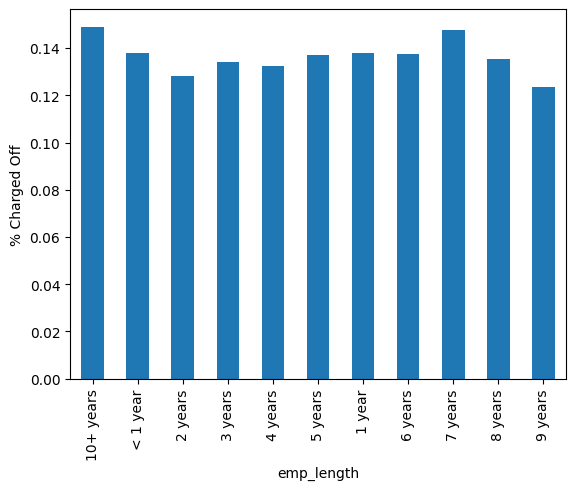

In [6]:
# ratio of loan_status 'Charged Off' based on emp_length vs total emp_length of each bucket
temp = loan_df.loc[loan_df['loan_status'] == 'Charged Off', 'emp_length'].value_counts() / loan_df['emp_length'].value_counts()
# histogram plot of temp with legend and y-axis named as 'Charged Off' in %
temp.plot(kind='bar', ylabel='% Charged Off')


Text(0.5, 0, 'Loan to Income')

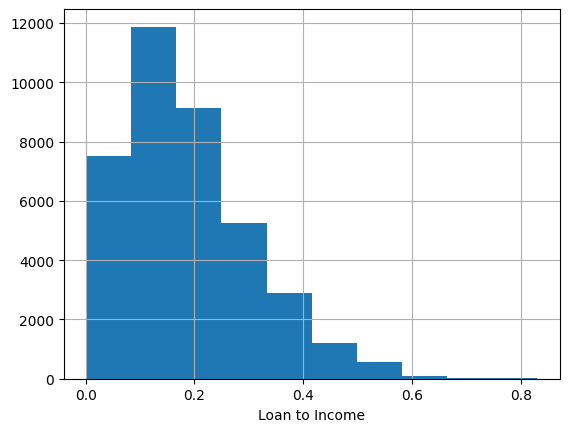

In [7]:
#histogram of loan_to_income with x-axis label as 'Loan to Income'
plt = loan_df['loan_to_income'].hist(bins=10)
#Add X axis label to .hist()
plt.set_xlabel('Loan to Income')



In [7]:
# percentage loan_to_income above 0.3
loan_df[loan_df['loan_to_income'] > 0.3].shape[0] / loan_df.shape[0]


0.1620437577768561

In [8]:
#Loan_to_income is more than 0.3 and previous loan status
#set fraud_flag as 1 if above condition met otherwise 0
loan_df['fraud_flag'] = 0
loan_df.loc[ (loan_df['loan_to_income'] > 0.3) & (loan_df['loan_status'] =='Charged Off'), 'fraud_flag'] = 1
#Get the value counts of fraud flag
loan_df['fraud_flag'].value_counts()


fraud_flag
0    37265
1     1311
Name: count, dtype: int64

As target feature derived, now prepare the features and target column for modeling with appropriate encoding and transformations.

In [15]:
# Set X from loan_df with features 'emp_length_num','home_ownership',
# 'verification_status', 'purpose', 'sub_grade'
X = loan_df[['emp_length','home_ownership', 'verification_status',
              'purpose', 'term','installment','int_rate','total_acc',
             'total_payment','dti']]

# Set y from loan_df with target feature 'fraud_flag'
y = loan_df['fraud_flag']


In [16]:
# Define categorical and numerical features
categorical_features = ['emp_length', 'home_ownership', 'purpose',
                        'term','verification_status']
numerical_features = [ 'dti',  'installment','int_rate',
                      'total_acc', 'total_payment']

# Define preprocessor for categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  # Apply StandardScaler to numeric features
        ('cat', OneHotEncoder(), categorical_features)  # One-hot encode categorical features
    ])

**Train/Test Split**
With data prepared, split it into a train and test set.

In [17]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**A Baseline Model**
Before first model, establish a baseline. What is the baseline performance that our classifier should aim to beat?

In [18]:
#Define and train a dummy classifier
dummy_classifier = DummyClassifier(strategy='most_frequent')
dummy_classifier.fit(X_train,y_train)

#Evaluate model accuracy & score
baseline_score = dummy_classifier.score(X_test,y_test)

### ANSWER CHECK
print("Baseline Model Score:",baseline_score)

Baseline Model Score: 0.9682477967858995


**A Simple Model**
Used Logistic Regression to build a basic model on loan data.

In [19]:
# Create pipeline with preprocessor and Logistic Regressor
simple_pipe = Pipeline([('preprocessor', preprocessor),
                     ('classifier', LogisticRegression(max_iter=1000))])
simple_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['dti', 'installment',
                                                   'int_rate', 'total_acc',
                                                   'total_payment']),
                                                 ('cat', OneHotEncoder(),
                                                  ['emp_length',
                                                   'home_ownership', 'purpose',
                                                   'term',
                                                   'verification_status'])])),
                ('classifier', LogisticRegression(max_iter=1000))])

**Score the Model**
What is the accuracy of simple model?

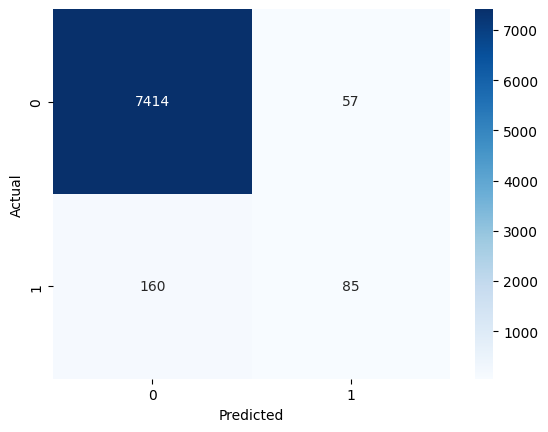

Simple LogisticRegression Model F1 Score: 0.4392764857881137


In [20]:
# Make predictions on the testing data
y_pred = simple_pipe.predict(X_test)

# Evaluate the model using a confusion matrix and plot with sns heatmap
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print("Simple LogisticRegression Model F1 Score:", f1)

In [21]:
#Evaluate simple model score
simple_model_score = simple_pipe.score(X_test,y_test)
simple_train_score = simple_pipe.score(X_train,y_train)

### ANSWER CHECK
print("Simple & Default Logistic test Score:",simple_model_score)
print("Simple & Default Logistic train Score:",simple_train_score)

Simple & Default Logistic test Score: 0.9718766200103681
Simple & Default Logistic train Score: 0.9705767984445884


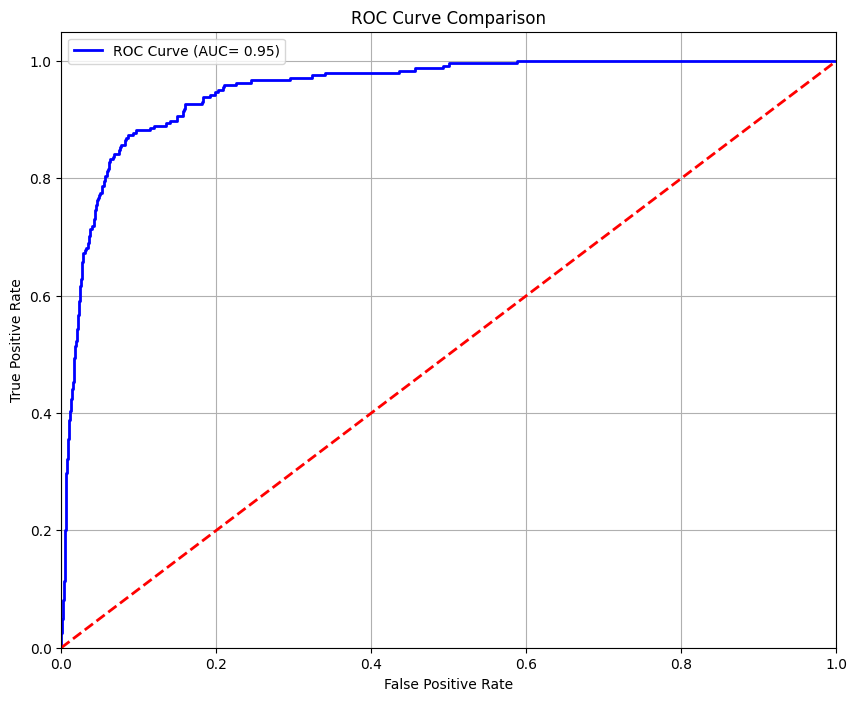

In [85]:
#simple_pipe
# Predict probabilities on the testing data
probas = simple_pipe.predict_proba(X_test)[:,1]
#probas
#y_test
#Compute ROC Curve & AUC
fpr, tpr, thresholds = roc_curve(y_test, probas)
roc_auc = auc(fpr, tpr)

# Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC Curve (AUC= %0.2f)' % roc_auc)
#plt.plot(fpr, tpr, label='Logistc' (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='r', lw= '2' )
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()

**Model Comparisons**
Compare the performance of the Logistic Regression model to other KNN algorithm, Decision Tree, and SVM models. Using the default settings for each of the models, fit and score each. Also, ccompared the fit time of each of the models

In [12]:
# Define classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'SVM': SVC(probability=True),
    'Random Forest': RandomForestClassifier()
}


Model Name: Logistic Regression
Logistic Regression: Training time: 0.3349s, Training accuracy: 0.9702
Model Name: KNN
KNN: Training time: 0.0724s, Training accuracy: 0.9728
Model Name: Decision Tree
Decision Tree: Training time: 0.6800s, Training accuracy: 1.0000
Model Name: SVM
SVM: Training time: 57.6925s, Training accuracy: 0.9732
Model Name: Random Forest
Random Forest: Training time: 14.1197s, Training accuracy: 1.0000


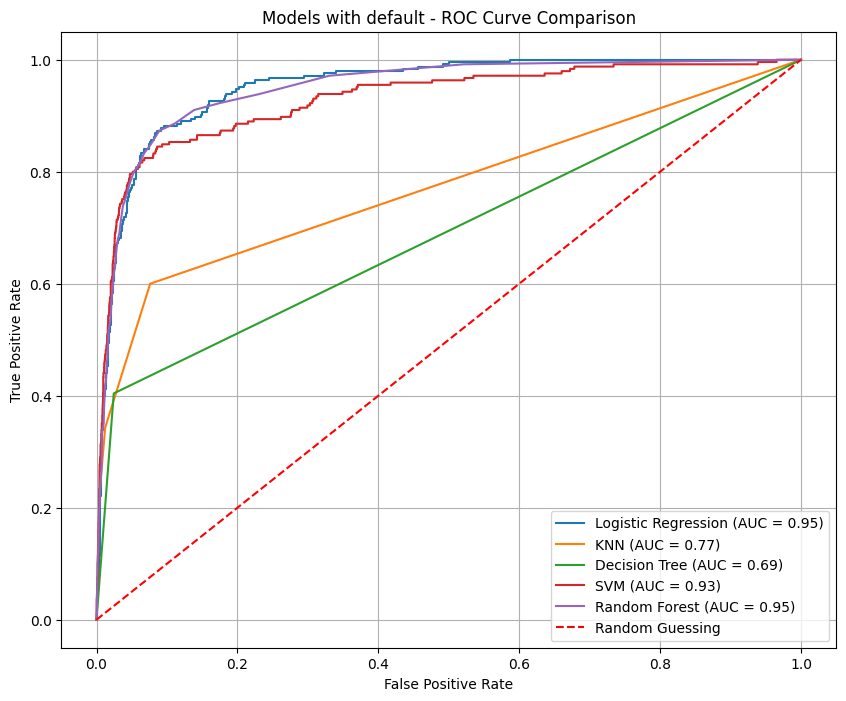

In [96]:
# Create an empty list to store individual DataFrames
dfs = []

# Train classifiers and plot ROC curves
plt.figure(figsize=(10, 8))
# Measure training time and evaluate training accuracy
for name, clf in classifiers.items():
    start_time = time.time()
    # Create pipeline with preprocessor and classifier
    pipe = Pipeline([('preprocessor', preprocessor),
                     ('classifier', clf)])
    pipe.fit(X_train, y_train)
    train_time = time.time() - start_time
    print("Model Name:",name)
    train_accuracy = pipe.score(X_train, y_train)
    # Make predictions on the testing data
    y_pred = pipe.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    # Evaluate test accuracy
    test_accuracy = pipe.score(X_test, y_test)
    model_df = pd.DataFrame({'Model': name, 'Train Time': train_time,
                             'Train Accuracy': train_accuracy,
                             'Test Accuracy': test_accuracy,
                             'F1 Score': f1}, index=[0])
    dfs.append(model_df)
    print(f"{name}: Training time: {train_time:.4f}s, Training accuracy: {train_accuracy:.4f}")
    #Predict probabilities on test set
    probas = pipe.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, probas[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')


# Plot ROC curve for random guessing (baseline)
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Guessing')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Models with default - ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()

In [97]:

default_result_df = pd.concat(dfs, ignore_index=True)
default_result_df

,Model,Train Time,Train Accuracy,Test Accuracy,F1 Score
0,Logistic Regression,0.334864,0.970188,0.971229,0.412698
1,KNN,0.072378,0.972813,0.971229,0.331325
2,Decision Tree,0.680034,1.000000,0.957361,0.375712
3,SVM,57.692477,0.973169,0.972395,0.389685
4,Random Forest,14.119743,0.999968,0.970710,0.270968


Improving the Model
Now with some basic models on the board, model improvement with few options

*   Hyperparameter tuning and grid search. All of our
models have additional hyperparameters to tune and explore. For example the number of neighbors in KNN or the maximum depth of a Decision Tree.
*   Adjust your performance metric





Best parameters for Logistic Regression: {'clf__C': 10, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Test accuracy of best model: 0.9711, Training time: 35.3540s
Best parameters for KNN: {'clf__n_neighbors': 9}
Test accuracy of best model: 0.9710, Training time: 309.0726s
Best parameters for Decision Tree: {'clf__max_depth': 5}
Test accuracy of best model: 0.9697, Training time: 7.0570s
Best parameters for SVM: {'clf__C': 1, 'clf__kernel': 'rbf'}
Test accuracy of best model: 0.9724, Training time: 883.0273s
Best parameters for Random Forest: {'clf__n_estimators': 100}
Test accuracy of best model: 0.9705, Training time: 320.4242s


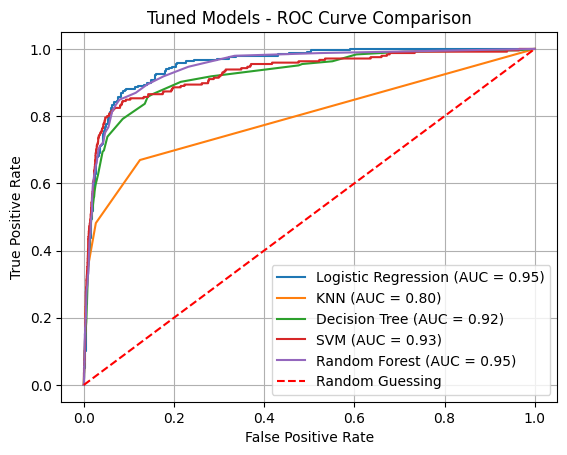

In [104]:
# Define parameter grids for hyperparameter tuning
param_grids = {
    'Logistic Regression': {'clf__C': [0.1, 1, 10], 'clf__penalty': ['l1', 'l2'],'clf__solver':['liblinear']},
    'KNN': {'clf__n_neighbors': [3, 5, 7,9]},
    'Decision Tree': {'clf__max_depth': [None, 5, 10, 20]},
    'SVM': {'clf__C': [ 1, 10], 'clf__kernel': ['linear', 'rbf']},
    'Random Forest': {'clf__n_estimators': [100, 200, 300]}
}


# Create an empty list to store individual DataFrames
tuned_dfs = []

# Perform hyperparameter tuning with GridSearchCV
for name, clf in classifiers.items():
    pipe = Pipeline([('preprocessor', preprocessor), ('clf', clf)])
    grid_param = param_grids[name]
    start_time = time.time()
    grid_search = GridSearchCV(pipe, param_grid=grid_param, cv=5,scoring='accuracy')
    grid_search.fit(X_train, y_train)
    fit_time = time.time() - start_time
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    # Evaluate best model on test set
    best_model = grid_search.best_estimator_
    tuned_train_score = grid_search.best_score_
    # Make predictions on the testing data
    y_pred = best_model.predict(X_test)
    tuned_f1 = f1_score(y_test, y_pred)
    # Evaluate best model on test set
    tuned_test_accuracy_best = best_model.score(X_test, y_test)
    print(f"Test accuracy of best model: {tuned_test_accuracy_best:.4f}, Training time: {fit_time:.4f}s")
    # Evaluate test accuracy
    #test_accuracy_best = best_model.score(X_test, y_test)
    tuned_model_df = pd.DataFrame({'Tuned Model': name, 'Train Time': fit_time,
                                   'Train Accuracy': tuned_train_score,
                                   'Test Accuracy': tuned_test_accuracy_best,
                                   'F1 Score': tuned_f1}, index=[0])
    tuned_dfs.append(tuned_model_df)

    #Predict probabilities on test set
    probas = grid_search.predict_proba(X_test)

    #Calculate ROC Curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test,probas[:,1])
    roc_auc = auc(fpr,tpr)

    #Plot ROC curve
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Plot ROC curve for random guessing (baseline)
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Guessing')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Tuned Models - ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()

In [105]:
#combine tuned model results as single DF
tuned_results_df = pd.concat(tuned_dfs, ignore_index=True)

tuned_results_df

,Tuned Model,Train Time,Train Accuracy,Test Accuracy,F1 Score
0,Logistic Regression,35.353974,0.969896,0.971099,0.411609
1,KNN,309.072622,0.968373,0.970969,0.286624
2,Decision Tree,7.056986,0.967012,0.969673,0.434783
3,SVM,883.027287,0.971030,0.972395,0.389685
4,Random Forest,320.424246,0.969216,0.970451,0.273885


**Feature Evaluation**
Potential impact of features to model could be direct or indirect. Tried with more than one technique to identify feature importance.

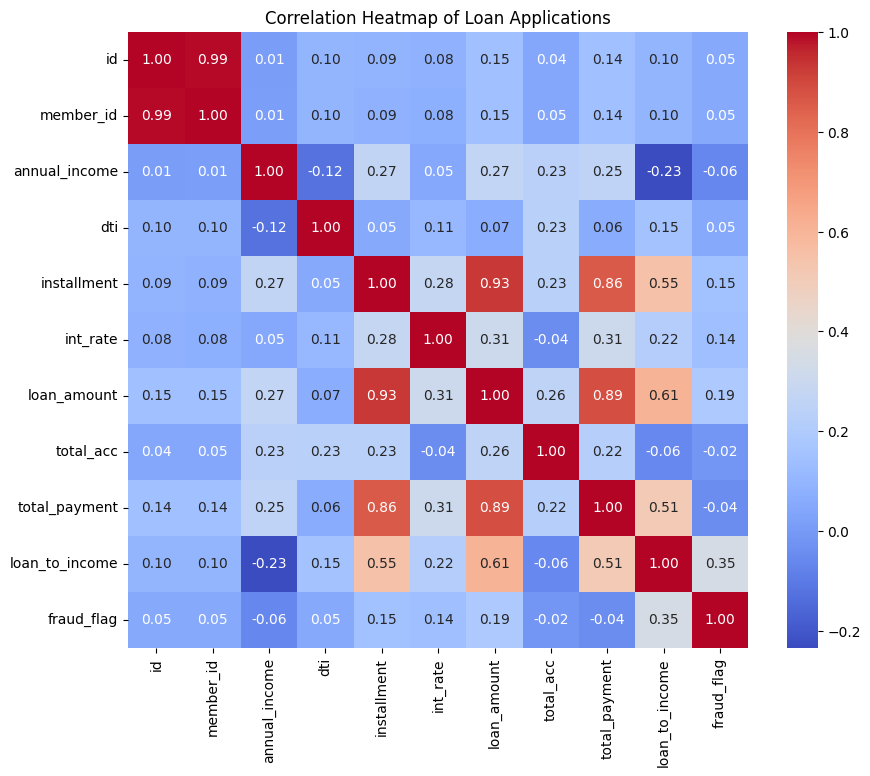

In [26]:

#Get numeric features for correlation matrix
numeric_data = loan_df.select_dtypes(include=['int64','float64'])
#Create correlation matrix
correlation_matrix =numeric_data.corr()
#Plot correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Loan Applications')
plt.show()

In [25]:
#Feature importance using permutation_importance and simple_pipe

result = permutation_importance(simple_pipe, X_train, y_train, n_repeats=10, random_state=42, n_jobs=-1)

#Get the feature importance scores
importance_scores = result.importances_mean

#print the feature importance in dataframe
feature_importance_df = pd.DataFrame({'Features': X_train.columns, 'Importance': importance_scores})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)



              Features  Importance
8        total_payment    0.083616
5          installment    0.082800
4                 term    0.005399
7            total_acc    0.001640
9                  dti    0.000587
6             int_rate    0.000506
3              purpose    0.000421
2  verification_status    0.000285
1       home_ownership    0.000279
0           emp_length    0.000272
